In [3]:
### Setup environment

!mkdir plots

### Install and load packages
 
#!pip install uncertainties     # uncomment to install dependancy
#!pip install lmfit             # for docs see https://lmfit.github.io/lmfit-py/


import lmfit

from scipy.optimize import curve_fit     # tool for curve fitting
import scipy                             # includes tools for data analysis
import scipy.stats
import numpy as np                       # import the tools of NumPy 
from matplotlib import pyplot as plt     # tools for plotting
import pandas as pd

import uncertainties as un               # tool set for handling  uncertainties
from uncertainties import unumpy as unp  # a replacement for numpy 

### Set global variables

location_data = "data/"         ## Use either local folder or github folder. 
location_styles = "styles/"     ## Use github locations for Colab
#location_data = "https://raw.githubusercontent.com/blinkletter/PythonPresentation/main/data/"
#location_styles = "https://raw.githubusercontent.com/blinkletter/PythonPresentation/main/styles/"

size = [4,4]
size2 = [4,5]
size3 = [2.5,2.5]


mkdir: plots: File exists


In [4]:
!cat data/Eryingdata1.csv

# from "Linear Eyring Plots Conceal a Change in the Rate-Limiting Step in an Enzyme Reaction"
# Teresa F. G. Machado, Tracey M. Gloster, and Rafael G. da Silva
# Biochemistry 2018 57 (49), 6757-6761
# https://doi.org/10.1021/acs.biochem.8b01099
#
# data for Figure 1: AbHBDH with Acetoacetate 
"TEMP(K)", "Kcat(s-1)", "Error(s-1)"
283,     3.4,      0.1  
288,     5.3,      0.2  
293,     7.6,      0.2   
298,     11.7,     0.3 
303,     15.2,     0.1 
308,     21.3,     0.9 
313,     27.8,     0.9 
318,     39,       3 
323,     52,       4 
325,     61,       2 
328,     69,       3 
330,     79,       7 

,TEMP(K),Kcat(s-1),Error(s-1)
0,283,3.4,0.1
1,288,5.3,0.2
2,293,7.6,0.2
3,298,11.7,0.3
4,303,15.2,0.1
5,308,21.3,0.9
6,313,27.8,0.9
7,318,39.0,3.0
8,323,52.0,4.0
9,325,61.0,2.0


slope = -5857.88+/-89.28
intercept = 16.34+/-0.29
rsq = 0.999
The change in enthalpy is 48705.16+/-742.32 kJ/mole
The change in entropy is -61.69+/-2.45 J/mole.K
Calculated k at T = 310 K is 24.05+/-0.24 s^-1


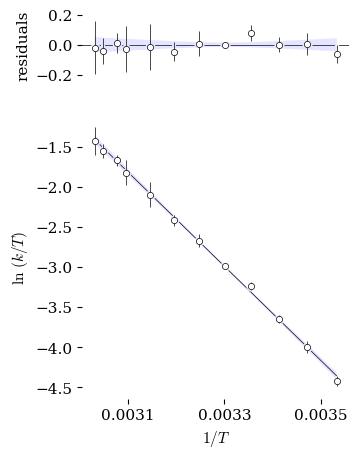

In [41]:
#### Eyring Plot with linear curve_fit

######################
### Read in data set
######################

datafile = "Eryingdata1.csv"   # change this file for new data
#datafile = "Eryingdata2.csv"   # change this file for new data
#datafile = "Eryingdata3.csv"   # change this file for new data
#datafile = "Eryingdata4.csv"   # change this file for new data

data = pd.read_csv(location_data+datafile, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="TEMP(K)", 
                 comment = "#") 
display(data)

######################
### Experimental data with error
######################

temp = data["TEMP(K)"]       # list of temperatures
k_obs = data["Kcat(s-1)"]      # list of observe rate constants (s^-1)
k_obs_err = data["Error(s-1)"]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = 1/temp
y_u = unp.log(k_obs_u/temp)   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

######################
###  Linear function to be used by curve_fit
######################
def linear(x, m, b):
    y = m * x + b
    return y

### Use curve_fit function           
popt, pcov = curve_fit(linear, x, y, sigma = y_err)  # use exp error

### Create new ufloat objects from returned parameters and covariance matrix 
(slope, intercept) = un.correlated_values(popt, pcov)

### print a report using the variables
print(f"slope = {slope:0.2f}")  
print(f"intercept = {intercept:0.2f}")  

r,p = scipy.stats.pearsonr(x,y)
rsq = r ** 2
print(f"rsq = {rsq:0.3f}")

######################
### calculate thermodynamic parameters
######################

R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - np.log(kb/h)) * R

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 310
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")

###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=size2, height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          teitle = Title,       
          ylabel=r"$\ln\,\left(k/T\right)$ ", 
          xlabel=r"$1/T$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
       )

### White background graphics
ax[1].scatter(x, y, marker = "o", s = 40, color = "white", zorder = 2)
### Data graphics
ax[1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 


### calculate y-values using best fit parameters
x_0 = np.linspace(np.min(x),np.max(x),100)       # for plotting from zero
best_fit_y = linear(x_0, slope, intercept)     # uncertain array of line fit

# Plot the curve fit line
ax[1].plot(x_0,unp.nominal_values(best_fit_y), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)


######################
#### Create Confidence band upper and lower bounds
######################
sigma = 2

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y) * sigma
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y) * sigma

# make filled band
ax[1].fill_between(x_0, fit_up, fit_dn, 
                   facecolor="blue", alpha=0.1, zorder = 2,
                   label="confidence interval")

# Add error bars
### White background graphics
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=1.5, dash_capstyle="round",
               zorder=1)
### Data graphics
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
             #  capsize=2, capthick=0.5, 
               zorder=3)

ax[1].set_xticks([0.0031,0.0033,0.0035])


######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = y - linear(x, slope.n, intercept.n)      

ax[0].set(
#          title = Title,       
          ylabel=r"residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-np.max(residuals)*3,np.max(residuals)*3]
       )
### White background Graphics
ax[0].scatter(x, residuals, marker = "o", s = 40, color = "white", zorder = 1)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=3, zorder=1)
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, dash_capstyle="projecting",
             #  capsize=2, capthick=0.5, 
               zorder=2)

# make filled band
ax[0].fill_between(x_0, unp.std_devs(best_fit_y) * sigma, -unp.std_devs(best_fit_y) * sigma, 
                   facecolor="blue", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='black', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/3F-1.pdf")
plt.show()


,TEMP(K),Kcat(s-1),Error(s-1)
0,283,3.4,0.1
1,288,5.3,0.2
2,293,7.6,0.2
3,298,11.7,0.3
4,303,15.2,0.1
5,308,21.3,0.9
6,313,27.8,0.9
7,318,39.0,3.0
8,323,52.0,4.0
9,325,61.0,2.0


---------- FIT REPORT ------------
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 12
    # variables        = 2
    chi-square         = 17.4581508
    reduced chi-square = 1.74581508
    Akaike info crit   = 8.49879980
    Bayesian info crit = 9.46861310
    R-squared          = -0.57535644
[[Variables]]
    m: -5857.88411 +/- 89.2802914 (1.52%) (init = -1000)
    b:  16.3401636 +/- 0.29494937 (1.81%) (init = -1)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, b) = -0.9997
RSQ = 0.999

      99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 m:-353.27669-203.88777 -93.97332-5857.88411 +93.97332+203.88777+353.27669
 b:  -1.16710  -0.67357  -0.31045  16.34016  +0.31045  +0.67357  +1.16710

 ------THERMODYNAMIC PARAMETERS - 1 sigma ---------
The change in enthalpy is 48705.16+/-742.32 J/mole
The change in entropy is -61.69+/-2.45 J/mole.K

-------- CHECK FIT ----------
ca

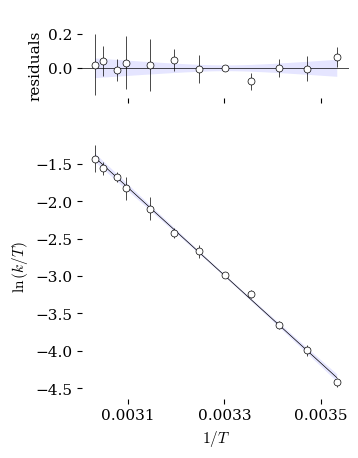

------------------------------------
---- Calc Thermo Params 95% CI -----
------------------------------------
The change in enthalpy is 48705.16+/-1695.22 kJ/mole
The change in entropy is -61.69+/-5.60 J/mole.K
Calculated k at T = 310 K is 24.05+/-0.56 s^-1


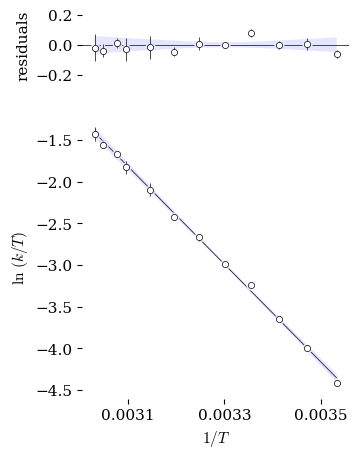

In [43]:
### LMFit

######################
### Read in data set
######################

datafile = "Eryingdata1.csv"   # change this file for new data
#datafile = "Eryingdata2.csv"   # change this file for new data
#datafile = "Eryingdata3.csv"   # change this file for new data
#datafile = "Eryingdata4.csv"   # change this file for new data

data = pd.read_csv(location_data+datafile, 
                 delimiter = ",", 
                 skipinitialspace=True, 
#                 index_col="TEMP(K)", 
                 comment = "#") 
display(data)

######################
### Experimental data with error
######################

temp = data["TEMP(K)"]       # list of temperatures
k_obs = data["Kcat(s-1)"]      # list of observe rate constants (s^-1)
k_obs_err = data["Error(s-1)"]  # list of standard deviations for data

### Convert lists to numpy arrays (enables numpy math tools with these lists)
temp = np.array(temp)
k_obs_u = unp.uarray(k_obs, k_obs_err)   # make an array of ufloat values

### Calculations for Erying plot axes
x = 1/temp
y_u = unp.log(k_obs_u/temp)   # y_u is now an array of ufloats

y = unp.nominal_values(y_u) # extract arrays of nominal values and errors
y_err = unp.std_devs(y_u)   # because curve_fit can handle ufloats

######################
###  Linear function to be used by curve_fit
######################
def linear(x, m, b):
    y = m * x + b
    return y

### Use curve_fit function  

# load the function f as the model to be fit
mod = lmfit.Model(linear)       

# state the parameters (use the text strings that we used above in the 
#   function) initial values are also set here
pars = mod.make_params(m=-1000, b=-1  )     
                                            
# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, x=x, weights=1.0/y_err)   


print("---------- FIT REPORT ------------")
print(result.fit_report())

r,p = scipy.stats.pearsonr(x,y); rsq = r**2
print(f"RSQ = {rsq:0.3f}")
print()

#print("--- PARAMETER CONFIDENCE INTERVALS ----")
print(result.ci_report())
#print()

intercept = result.uvars['b']      # collect parameters as uncertain values 
slope = result.uvars['m']

Temp = 310
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - np.log(kb/h)) * R

print("\n ------THERMODYNAMIC PARAMETERS - 1 sigma ---------")
print(f"The change in enthalpy is {dH:0.2f} J/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")
print()

## calculate k from Erying plot parameters.
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print("-------- CHECK FIT ----------")
print(f"calculate k at T={Temp} K is {kobs:0.2f}")

### PLOT

plt.rcdefaults()
style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

#intercept = result.uvars['b']      # collect parameters as uncertain values 
#slope = result.uvars['m']

fig = plt.figure(figsize = size2)
result.plot(fig = fig,
            fig_kws = {},      # this is a keyword dictionary for figure styles
            xlabel = r"$1/T$",
            ylabel = r"$\ln \left( k/T \right)$",
            yerr = 2*y_err,
            title = " ",
            data_kws ={"color":"black", "linestyle":"None", "linewidth": 0.5,
                       "markerfacecolor": "white", "markeredgecolor":"black", "markersize":5,
                       "markeredgewidth":0.5, "zorder":3},
            fit_kws ={"linewidth": 0.5, "zorder":2},
            ax_res_kws = {},   # 'kws' is 'keyword styles'
            ax_fit_kws = {},
            )
 
ax = fig.axes   # get the axes from the plot (there are two in a list)

ax[1].set_xticks([0.0031,0.0033,0.0035]) # These will be the ticks for both axes

### Confidence band
sigma = 2

x_0 = np.linspace(np.min(x), np.max(x), 100)
y_0 = result.eval(x=x_0)
dely = result.eval_uncertainty(x=x)
dely_0 = result.eval_uncertainty(x=x_0, sigma=sigma)

ax[1].fill_between(x_0, y_0-dely_0, y_0+dely_0, 
                   linewidth=0, color='blue', alpha = 0.1, zorder=1
                   )
ax[0].fill_between(x_0, -dely_0, dely_0, 
                   linewidth=0, color='blue', alpha = 0.1, zorder=1
                   )

### do not show legend 
#fig.legend([])
ax[1].legend([])      # blank legend

plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/3F-02.pdf")
plt.show()


print("------------------------------------")
print("---- Calc Thermo Params 95% CI -----")
print("------------------------------------")

slope_ci95 = result.ci_out["m"][1][1] - result.ci_out["m"][3][1]
int_ci95 = result.ci_out["b"][1][1] - result.ci_out["b"][3][1]
slope_best = result.ci_out["m"][3][1]
int_best = result.ci_out["b"][3][1]

# I want to use the correlation matrix for the results.uvars parameters
#  but I want to use the 95% confidence interval as the error.

# make correlation matrix from the uvars (note correlation matrix is 
#  different than covariance matrix)

corr_matrix = un.correlation_matrix([result.uvars["m"], result.uvars["b"]])

(slope, intercept) = un.correlated_values_norm([(slope_best,slope_ci95),
                                               (int_best, int_ci95)],
                                               corr_matrix)



### calculate thermodynamic parameters
R = scipy.constants.R
kb = scipy.constants.k
h = scipy.constants.h
kappa = 1

dH = -slope * R
dS = (intercept - np.log(kb/h)) * R

print(f"The change in enthalpy is {dH:0.2f} kJ/mole")
print(f"The change in entropy is {dS:0.2f} J/mole.K")

## calculate k from Erying plot parameters.
Temp = 310
kobs = (kappa * kb / h) * Temp * unp.exp(-dH/(R*Temp)) * unp.exp(dS/R)
print(f"Calculated k at T = {Temp} K is {kobs:0.2f} s^-1")




###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=size2, height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          teitle = Title,       
          ylabel=r"$\ln\,\left(k/T\right)$ ", 
          xlabel=r"$1/T$",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
#          ylim=[None,None]
       )

### White background graphics
ax[1].scatter(x, y, marker = "o", s = 40, color = "white", zorder = 2)
### Data graphics
ax[1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 


### calculate y-values using best fit parameters
x_0 = np.linspace(np.min(x),np.max(x),100)       # for plotting from zero
best_fit_y = linear(x_0, slope, intercept)     # uncertain array of line fit

# Plot the curve fit line
ax[1].plot(x_0,unp.nominal_values(best_fit_y), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)


######################
#### Create Confidence band upper and lower bounds
######################
sigma = 1

# upper and lower bounds of uncertain kobs as float values
fit_up = unp.nominal_values(best_fit_y) + unp.std_devs(best_fit_y) * sigma
fit_dn = unp.nominal_values(best_fit_y) - unp.std_devs(best_fit_y) * sigma

# make filled band
ax[1].fill_between(x_0, fit_up, fit_dn, 
                   facecolor="blue", alpha=0.1, zorder = 2,
                   label="confidence interval")

# Add error bars
### White background graphics
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=1.5, dash_capstyle="round",
               zorder=1)
### Data graphics
ax[1].errorbar(x, y, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, 
             #  capsize=2, capthick=0.5, 
               zorder=3)

ax[1].set_xticks([0.0031,0.0033,0.0035])


######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = y - linear(x, slope.n, intercept.n)      

ax[0].set(
#          title = Title,       
          ylabel=r"residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-np.max(residuals)*3,np.max(residuals)*3]
       )
### White background Graphics
ax[0].scatter(x, residuals, marker = "o", s = 40, color = "white", zorder = 1)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="white", elinewidth=3, zorder=1)
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
ax[0].errorbar(x, residuals, yerr=y_err*sigma, xerr=None, fmt="None", 
               ecolor="black", elinewidth=0.5, dash_capstyle="projecting",
             #  capsize=2, capthick=0.5, 
               zorder=2)

# make filled band
ax[0].fill_between(x_0, unp.std_devs(best_fit_y) * sigma, -unp.std_devs(best_fit_y) * sigma, 
                   facecolor="blue", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='black', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])


### Output plot
plt.tight_layout(pad=2, h_pad=None, w_pad=None, rect=None)
plt.savefig("plots/3F-2B.pdf")
plt.show()


In [20]:
result.ci_out["m"][1][1] - result.ci_out["m"][3][1]

-203.88776976561167

In [18]:
result.ci_out

{'m': [(0.9973002039367398, -6211.160800121909),
  (0.9544997361036416, -6061.771884535829),
  (0.6826894921370859, -5951.857433780198),
  (0.0, -5857.884114770217),
  (0.6826894921370859, -5763.910795769204),
  (0.9544997361036416, -5653.996345013559),
  (0.9973002039367398, -5504.607429427469)],
 'b': [(0.9973002039367398, 15.17306689138135),
  (0.9544997361036416, 15.666593131915626),
  (0.6826894921370859, 16.02971020421647),
  (0.0, 16.340163618080208),
  (0.6826894921370859, 16.650617031973496),
  (0.9544997361036416, 17.01373410427437),
  (0.9973002039367398, 17.507260344808614)]}

In [21]:
result.uvars

{'m': -5857.884114770217+/-89.2802913529175,
 'b': 16.340163618080208+/-0.2949493700512138}

In [23]:
un.correlation_matrix([result.uvars["m"], result.uvars["b"]])

array([[ 1.        , -0.99968005],
       [-0.99968005,  1.        ]])